# PROJECT 2

Course: From Shallow To Deep Learning 

Author: Nicolas Arrieta Larraza

Date: 25-01-2021

## Initializating

### Import

In [1]:
!pip uninstall -y opencv-python
!pip uninstall -y opencv-contrib-python
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 25.0MB 132kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6MB 109kB/s 


In [2]:
%matplotlib inline
import os
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
from google.colab import drive
import torchvision.datasets as datasets
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import tqdm.notebook as tq
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import VGG16
from skimage.transform import resize

### Configuration

In [3]:
drive.mount('/content/drive') 

Mounted at /content/drive


### Dataset initialization

In [4]:
path = "/content/drive/MyDrive/UCA/FS2DL/Datasets/VOC2007"
os.chdir(path)
os.listdir(path)
voc_trainset = datasets.VOCDetection(path,year='2007', image_set='train', download=False)

## First task: Extend Near Duplicate to Classification

*With your results of the previous project, try to find an optimal threshold to retrieve all the images of a given category.*

We are going to define a function to try to retrieve all the images from a category with respect to a threshold. In this case the treshold that we chose is the **distance** between descriptors in a match.

Briefly description of the function:


*   It takes as parameters the image and its label and the value of the threshold

*   The function compare the image with every image of the dataset, finds the matches between them, compute the distances and their average and finally compare the distance average with the threshold to classify the picture.

*    It returns an array of the classes detected, an accuracy value of the images detected and an error value showing the percentage of images that were of the same class but were not detected. 




In [5]:
def find_all_image_by_category(base_img, category, threshold):

  detections = []
  TP = 0
  TN = 0
  n_cat = 0
  base_img = cv.cvtColor(base_img,cv.COLOR_BGR2GRAY)

  for i in tq.tqdm(range(len(voc_trainset))):

      img = np.array(voc_trainset[i][0])
      img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
      label = voc_trainset[i][1].get("annotation").get("object")[0].get("name")
      if label == category:
        n_cat+=1

      sift = cv.xfeatures2d.SIFT_create()
      kp1, des1 = sift.detectAndCompute(base_img,None)
      kp2, des2 = sift.detectAndCompute(img,None)

      # BFMatcher with K=2 -> For each keypoint we keep the best 2 matches (less distance)
      bf = cv.BFMatcher()
      matches = bf.knnMatch(des1,des2, k=2)

      # Apply D.Lowe ratio test -> 
      #for each 2 pair of best matches, 
      #if the distance of the best match is lower that the 75% of the distance of the second it is considered a good match.
      good = []
      for m,n in matches:
          if m.distance < 0.75*n.distance:
              good.append([m])

      sum_dist = 0
      #Average of distances
      for m in good:
        sum_dist += m[0].distance

      if len(good) == 0:
        avg = threshold
      else:
        avg = sum_dist / len(good) 

      #Saves best match
      if avg < threshold:
        detections.append([i,label])
        if label == category:
          TP +=1 #True positives
      elif label != category:
        TN +=1 #True negatives

  missed = 100 - (TP*100/n_cat)

  accuracy = (TP+TN)*100/len(voc_trainset)

  
  return detections, accuracy, missed



### Example 1

For the first example we will work with the "car" category

Category:  car


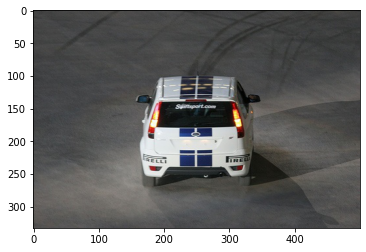

In [6]:
image, annotation = voc_trainset[0][0],voc_trainset[0][1]
label = annotation.get("annotation").get("object")[0].get("name")
print("Category: ", label)
img = np.array(image)
plt.imshow(img)
plt.show()

After a few attempts, it seems that a value of 200 for the threshold might be accurate enough.

In [7]:
detections, accuracy, missed = find_all_image_by_category(img, "car", 150)

In [8]:
print("Detections: {} \n".format(detections))
print("Accuracy: {}% \n".format(accuracy))
print("Images missed of the same category: {}% \n".format(missed))


Detections: [[0, 'car'], [104, 'dog'], [176, 'cow'], [200, 'diningtable'], [266, 'cow'], [643, 'bird'], [682, 'person'], [693, 'bird'], [760, 'car'], [783, 'person'], [821, 'person'], [883, 'bird'], [897, 'person'], [1006, 'cat'], [1036, 'bus'], [1249, 'cat'], [1335, 'car'], [1423, 'bird'], [1498, 'person'], [1533, 'person'], [1650, 'person'], [1667, 'dog'], [1768, 'chair'], [1865, 'bottle'], [1966, 'bicycle'], [2112, 'cat'], [2200, 'bus'], [2278, 'car'], [2301, 'train'], [2393, 'cow']] 

Accuracy: 87.48500599760096 

Images missed of the same category: 98.62542955326461 



### Example 2

For the secod example we will work with the "cat" category

Category:  cat


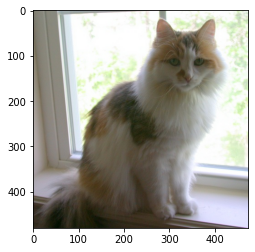

In [9]:
image_2, annotation_2 = voc_trainset[24][0],voc_trainset[24][1]
label_2 = annotation_2.get("annotation").get("object")[0].get("name")
print("Category: ", label_2)
img_2 = np.array(image_2)
plt.imshow(img_2)
plt.show()

In [10]:
detections_2, accuracy_2, missed_2 = find_all_image_by_category(img_2, "cat", 150)

In [11]:
print("Detections: {} \n".format(detections_2))
print("Accuracy: {}% \n".format(accuracy_2))
print("Images missed of the same category: {}% \n".format(missed_2))

Detections: [[7, 'person'], [24, 'cat'], [29, 'dog'], [30, 'bird'], [51, 'motorbike'], [81, 'diningtable'], [86, 'person'], [109, 'car'], [125, 'bicycle'], [132, 'person'], [144, 'person'], [173, 'bus'], [223, 'dog'], [233, 'person'], [267, 'dog'], [275, 'train'], [316, 'chair'], [332, 'bottle'], [361, 'person'], [368, 'bird'], [373, 'cat'], [397, 'chair'], [401, 'sheep'], [419, 'motorbike'], [430, 'dog'], [440, 'sofa'], [518, 'tvmonitor'], [529, 'train'], [543, 'cat'], [548, 'cat'], [586, 'dog'], [607, 'person'], [639, 'person'], [665, 'sheep'], [683, 'train'], [708, 'sofa'], [727, 'bicycle'], [738, 'bicycle'], [740, 'pottedplant'], [757, 'car'], [767, 'dog'], [775, 'person'], [795, 'tvmonitor'], [805, 'train'], [840, 'person'], [845, 'sheep'], [874, 'train'], [896, 'bottle'], [920, 'cat'], [939, 'person'], [950, 'chair'], [960, 'car'], [986, 'sofa'], [1067, 'car'], [1105, 'motorbike'], [1175, 'person'], [1221, 'person'], [1231, 'person'], [1250, 'boat'], [1291, 'chair'], [1307, 'pott

### Analysis of implementation

 In the light of the results, it seems that the method implemented is not good enough for image retrieval for the following reasons:

1.   It takes long computational time (**~40 minutes** for each image retrieval) for a small-medium size dataset 
(**2501 items**). It makes sense since the program has to compute the features and compare the matches with our query for all the images in the dataset. This shows the non-scalability of the model.
2.   The performance metrics show a poor model with a low accuracy and high percentage of missed images:

    *   Case of car image retrieval:
      *   For a threshold of **200**, the model resulted in an accuracy of **12%** and a **76.6%** of images missed
      *   For a threshold of **150**, the model resulted in an accuracy of **13.3%** and a **98.62%** of images missed

    *   Case of cat image retrieval:
      *   For a threshold of **200**, the model resulted in an accuracy of **6.86%** and a **62%** of images missed
      *   For a threshold of **150**, the model resulted in an accuracy of **7.8%** and a **94.1%** of images missed   

## Second Task: Bag-of-Word model for Image Classification

As mentioned in class, the previous model is not scalable. Therefore in this second task we are going to implement a image searche engine base on the Bag Of Visual Words (BOVW) approach.

### Computing descriptors dataset

Let's compute the descriptors of all the images of the dataset.

In [12]:
def get_descriptors():
  descriptors = []
  #Computing descriptors of the whole dataset
  for i in tq.tqdm(range(len(voc_trainset))):
    img = np.array(voc_trainset[i][0])
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    for d in des:
      descriptors.append(d)
  
  return descriptors



In [13]:
descriptors_ds = get_descriptors()
len(descriptors_ds)

2011315

This will be the dataset for the K-Means algorithm. Each descriptor contains 128 features, ergo the algorithm will be working on a 128 feature space.

### K-Means

In order to compute the K-Means algorithm we first need to determine the number of final clusters **K**. This will be the size of our Bag of Words (The number of characteristic features). To achieve this we will carry the **Elbow** analysis technique. (We tried to apply the **Silhouette** analysis technique, however the computational time was extremely extensive)

The characteristics of the K-Means algorithm that we will use in the analysys are the following:

*   Halting criteria: The algorithm stops if one of these 2 conditions is achieved:

  *   Number of maximum iterations = **10** (Small to save computational time)
  *   Tolerance = **1e-4** (Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.)

*   The algorithm is **run 10 times** with **random centroids initialization** and it returns the best result of all in terms of compactness (SSE from each point to their corresponding centers)









#### Elbow analysis

K-Means computed for 15 clusters!
K-Means computed for 16 clusters!
K-Means computed for 17 clusters!
K-Means computed for 18 clusters!
K-Means computed for 19 clusters!
K-Means computed for 20 clusters!
K-Means computed for 21 clusters!
K-Means computed for 22 clusters!
K-Means computed for 23 clusters!
K-Means computed for 24 clusters!



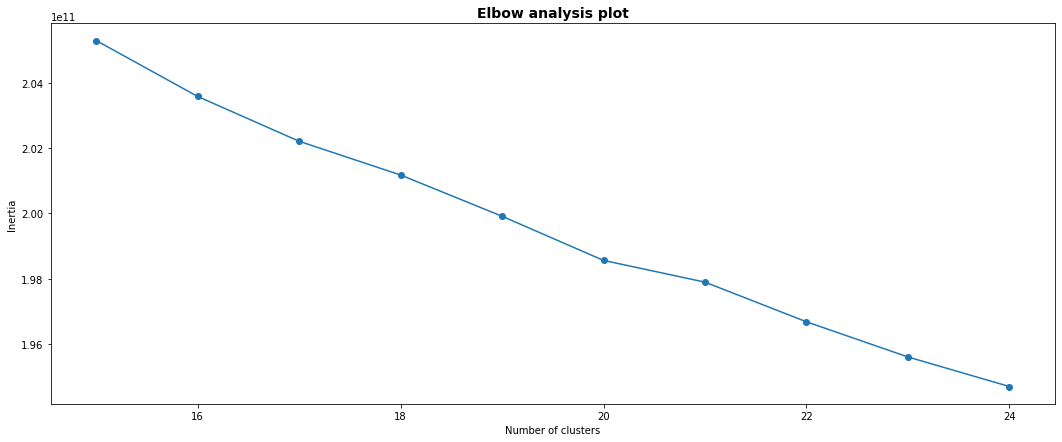

In [ ]:
num_clusters = range(15,25) # we will analyse n_clusters from 15 to 25
SSE = []

for n_clusters in tq.tqdm(num_clusters):

    # Initializing the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10, max_iter=10)
    kmeans.fit(descriptors_ds)

    labels_pred = kmeans.predict(descriptors_ds)

    print("K-Means computed for {} clusters!".format(n_clusters))

    #Computing k means inertia for elbow analysis
    SSE.append(kmeans.inertia_)

fig, a = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
plt.plot(num_clusters, SSE, marker='o')
plt.title('Elbow analysis plot', fontsize=14, fontweight='bold')
a.set_xlabel('Number of clusters')
a.set_ylabel('Inertia')
plt.show()

The elbow analysis plot shows the inertia of the K-Means for different number of clusters. The inertia is defined as the sum of squared distances of samples to their closest cluster center, i.e. SSE.

The analysis has been done **3 times** for clusters from **15 to 25, 25 to 35 and 35 to 55**. The results for all of them are very similar and inconclusive. We can't run the analysis from 15 to 55 because of computational time (35 to 55 took more than 4h).

Since we were not able to run the silhouette analysis neither, we choose a **K=20** by the recommendation of professors.



#### Computing K-Means 

In consideration of the previous analysis, let's compute the K-Means algorithm with **K=20**

In [14]:
kmeans = KMeans(n_clusters=20, random_state=10, max_iter=100)
labels_pred = kmeans.fit_predict(descriptors_ds)

### Building feature histogram of images

Now let's build an histogram per image to represent the frequency of the K labels in that image. (We count the labels assigned by K-Means to the descriptors of each image)

In [ ]:
def get_histograms(labels):
  previous=0
  histograms = []
  for i in tq.tqdm(range(len(voc_trainset))):
    img = np.array(voc_trainset[i][0])
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)

    hist = [0]*20
    img_labels = labels[previous:previous+len(des)]
    for label in img_labels:
      hist[label] += 1
    
    histograms.append(hist)
    previous = previous+len(des)
  
  return histograms
  

In [ ]:
histograms = get_histograms(labels_pred)

Let's plot the first 3 images to observe the result:

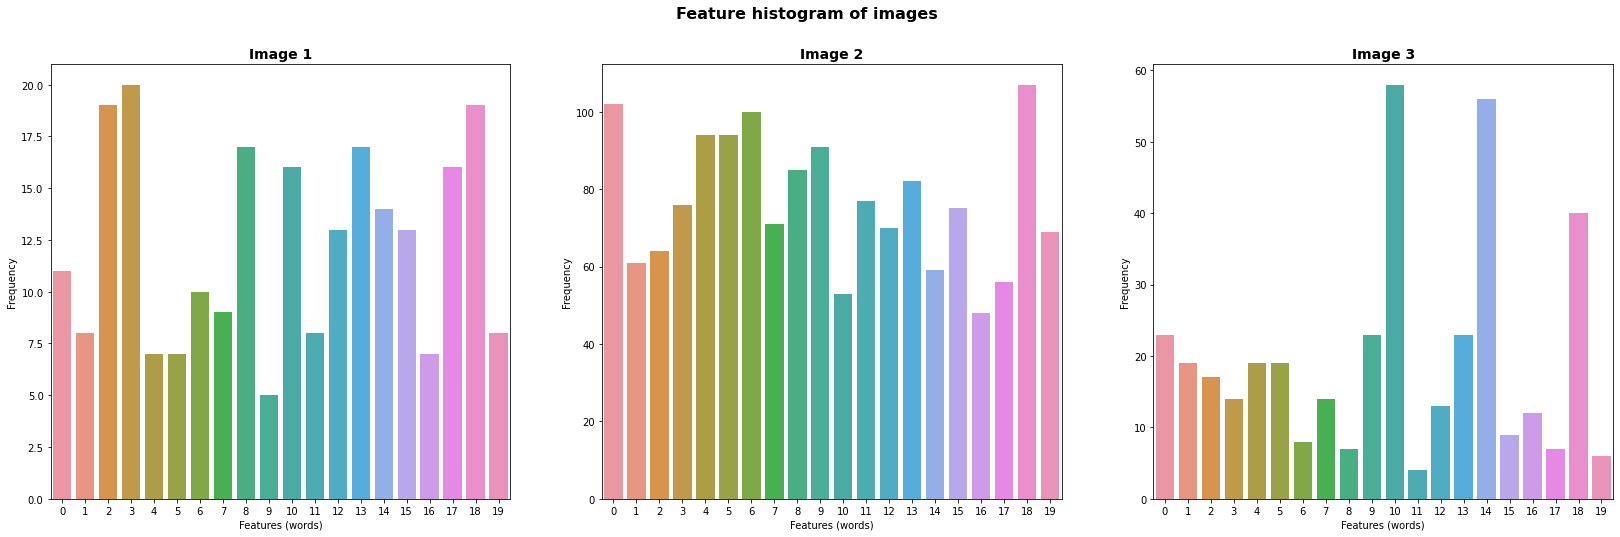

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(28,8))
fig.suptitle('Feature histogram of images', fontsize=16,fontweight='bold')

x= np.arange(0,20)
y= histograms[0]
sns.barplot(ax=axes[0],x=x,y=y)
axes[0].set_title('Image 1',fontsize=14,fontweight='bold')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Features (words)')

y_1= histograms[1]
sns.barplot(ax=axes[1],x=x,y=y_1)
axes[1].set_title('Image 2',fontsize=14,fontweight='bold')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Features (words)')

y_2= histograms[4]
sns.barplot(ax=axes[2],x=x,y=y_2)
axes[2].set_title('Image 3',fontsize=14,fontweight='bold')
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Features (words)')

plt.show()


### Training neural network to classify different categories

Based on the feature histogram dataset generate in the previous section, we are going to train a neural network to classify several categories

First we extract the classes of the original dataset:

In [ ]:
classes = []
images = []
for i in tq.tqdm(range(len(voc_trainset))):
  label = voc_trainset[i][1].get("annotation").get("object")[0].get("name")
  img = np.array(voc_trainset[i][0])
  img_resized = resize(img, (300, 300))
  classes.append(label)
  images.append(img_resized)


Below one can find the implementation of the neural network model as following:
  

*   **Data**: We use the histogram dataset as input data for the model and the classes extracted from the original dataset as labels. (Divided in training and test datasets)
*   **Network**: The network consists of 3 fully-connected layers described as following:

  1.   First layer of input dimension 20 (Number of words in our dictionary) and output dimension 64. Activation function "ReLu".
  2.   Second layer of input dimension 64 and output dimension 16. Activation function "ReLu".
  3.   Third layer of input dimension 16 and output dimension 20 (Number of labels).Activation function "SoftMax".

*  **Model**:

  *   Loss function: Categorical cross entropy
  *   Optimizer: Adam
  *   Early stopping checking the value of the validation accuracy in case of constant or worse new values

*   **Training**:
  *   Number of epochs: 100
  *   Batch size: 64








(2501, 20)
Epoch 1/100
36/36 [==============================] - 1s 8ms/step - loss: 15.5178 - accuracy: 0.0420 - val_loss: 3.8887 - val_accuracy: 0.1554
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 3.1810 - accuracy: 0.1442 - val_loss: 3.5791 - val_accuracy: 0.1833
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 3.1114 - accuracy: 0.1639 - val_loss: 3.3579 - val_accuracy: 0.1713
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 3.0055 - accuracy: 0.1531 - val_loss: 3.3055 - val_accuracy: 0.1713
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 2.9587 - accuracy: 0.1727 - val_loss: 3.1979 - val_accuracy: 0.1713
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 2.9685 - accuracy: 0.1691 - val_loss: 3.1169 - val_accuracy: 0.1753
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 2.9358 - accuracy: 0.1755 - val_loss: 3.1049 - val_accuracy: 0.1793
E

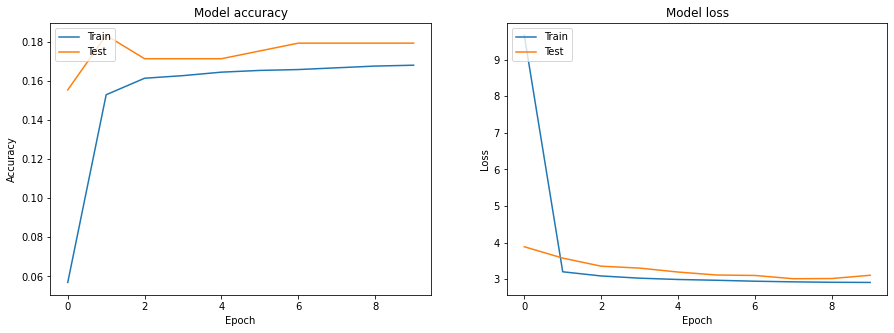

In [ ]:
#Histogram dataset
X = histograms
X = np.array(X)

#Classes retrieved from the original image dataset
y = np.array(classes)
y = y.reshape(-1,1)

#Encoding classes trough a OneHotEncoder
ohe = OneHotEncoder()
# Convert categorical data to binary array
y = ohe.fit_transform(y).toarray()

print(y.shape)

# Spliting data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

vocabulary_size = 20 #Number of clusters computed (the number of "words" in the dictionary)
n_classes = 20 #Number of classes (labels) of the original dataset

# Model
model = Sequential()
model.add(Dense(64, input_dim=vocabulary_size, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implementing early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8)

#Training model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=64, callbacks=[early_stopping])

# Test the model
y_pred = model.predict(X_test)
a = accuracy_score(np.argmax(y_pred, axis=-1), np.argmax(y_test, axis=-1))
print(f'Accuracy is: {a * 100}')

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss']) 
ax[1].set_title('Model loss') 
ax[1].set_ylabel('Loss') 
ax[1].set_xlabel('Epoch') 
ax[1].legend(['Train', 'Test'], loc='upper left') 
plt.show()


### Analysis of implementation

As it can be observed by the results of the model, there is an **improvement** in the overall accuracy of the implementation with respect to the previous attempt of descriptors matching approach. However, the **accuracy is still low and unstable** which lead us to think that it is still a **weak implementation** for an image classification system.

The metrics in the last run shows an accuracy of **17.92%**, however the value changes between 15% and 22% more or less every time the model is run.

Also the model is trained just in a few epochs since the validation accuracy drops its increasing tendency very quickly.



## Third Task: Using Convolutional Neural Network to represent Images

In this last section we use a pretrained Deep Neural Network to classify the images directly.

### Loading model

We use a **VGG16** model already pretrained from Keras' library as the suggestion of the project description. It is worth to mention that the model is loaded **without the top layers** (which consists of fully connected layers) and that we are going to **freeze all of the layers**.

In [7]:
# Load the VGG model
image_size = 300
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers
for layer in vgg_conv.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f289719dd68> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f28b46c17b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27eccfc4e0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f27ecccd320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27eccd33c8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27eccd3fd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f27eccdab00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27ecce1668> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27ecce85f8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27ecce1f60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f27e9582e48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

### Modifying model

We modify the model by adding a few layers at the end of the model as following:

  1.    Flatten layer to flatten the output of the VGG16 model
  2.   Fully-connected layer of output dimension 100. Activation function "ReLu".
  4.   A final Fully-connected layer of output dimension 20 (Number of labels). Activation function "Softmax".

And for the model parameters we choose:

  *   Loss function: Categorical cross entropy
  *   Optimizer: Adam

In [8]:
n_classes = 20

model_2 = Sequential()
model_2.add(vgg_conv)
model_2.add(Flatten())
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(n_classes, activation='softmax'))

In [9]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Training Model

First, we prepare the data for the model and divide it in training and test portions.

In [10]:
X = np.array(images)

y = np.array(classes)
y = y.reshape(-1,1)

In [ ]:
# Convert categorical data to binary array
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

# Spliting data between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

Then we train the model with the training data using GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
trained_model_2 = model_2.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=64)

In [ ]:
# Test the model
y_pred = model_2.predict(X_test)
a = accuracy_score(np.argmax(y_pred, axis=-1), np.argmax(y_test, axis=-1))
print(f'Accuracy is: {a * 100}')

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(trained_model_2.trained_model_2['accuracy'])
ax[0].plot(trained_model_2.trained_model_2['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(trained_model_2.trained_model_2['loss'])
ax[1].plot(trained_model_2.trained_model_2['val_loss']) 
ax[1].set_title('Model loss') 
ax[1].set_ylabel('Loss') 
ax[1].set_xlabel('Epoch') 
ax[1].legend(['Train', 'Test'], loc='upper left') 
plt.show()

##**IMPORTANT NOTE:** 
I have not been able to run the model since the RAM allocation given by Google Colab runs out of space showing the message "*Your session crashed after using all available RAM*". This happended while hot encoding the classes.

Still I have written the code of every step as it should be done.